# affine invariant ensemble sampler + parallel tempering

### 12D transporter model (single antiporter cycle)

10736.513516166175


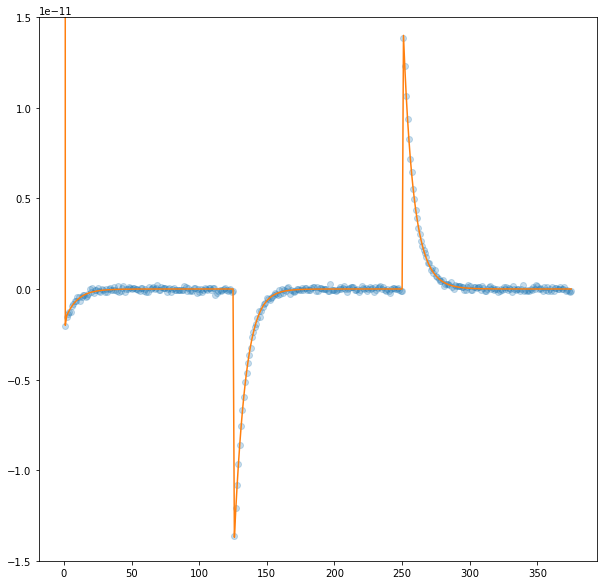

In [1]:
import numpy as np, tellurium as te, matplotlib.pyplot as plt
import emcee as mc, corner
np.random.seed(10)


# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


antimony_string = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = H_out_activation, S_out = S_out_activation;
            E2: at (time >= 10): H_out = 1e-7, S_out = 0.001;

            // Species initializations:
            H_out = 1e-07;
            H_out has substance_per_volume;

            H_in = 1e-7;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 1e-3;
            S_in has substance_per_volume;

            OF = 2.833e-8;
            OF has substance_per_volume;

            OF_Hb = 2.833e-8;
            OF_Hb has substance_per_volume;

            IF_Hb = 2.833e-8;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 2.833e-8;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 2.125e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 2.125e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Variable initializations:
            H_out_activation = 5e-8;
            S_out_activation = 0.001;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
            """ 


m = te.loada(antimony_string)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12

D = m.simulate(0, 15, 376, selections=['time', 'rxn4'])
y_true = D['rxn4']

noise_stdev_true = 1e-13
#y_obs = y_true + np.random.normal(0, noise_stdev_true, len(y_true))
y_obs = np.genfromtxt("data_grid_test3.csv", skip_header=1)

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o', alpha=0.25)
plt.plot(y_true)
plt.ylim(-1.5e-11, 1.5e-11)

log_like_ref = calc_norm_log_likelihood(y_true,noise_stdev_true,y_obs)

print(log_like_ref)

In [2]:
import time


def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    sigma = 10**theta[0]
    K=theta[1:]
    m = extra_parameters[0] 
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)

    try:
        D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
        y_tmp = D_tmp['rxn4']
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    except:
        log_like_tmp = -np.inf
    return log_like_tmp


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def log_prior(theta):
    '''log of uniform prior distribution'''
    p0 = theta[0]
    p1 = theta[1]
    p2 = theta[2]
    p3 = theta[3]
    p4 = theta[4]
    p5 = theta[5]
    p6 = theta[6]
    p7 = theta[7]
    p8 = theta[8]
    p9 = theta[9]
    p10 = theta[10]
    p11 = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p0<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior


def set_p0():
    log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
    log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

    log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)

    ## near max likelihood
#     log_noise_sigma = np.random.uniform(np.log10(0.99e-13), np.log10(1.01e-13))
#     log_k1_f = np.random.uniform(9.99, 10.01) # log10 rate constant (ref=1e10)
#     log_k1_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3)
#     log_k2_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k2_r = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k3_f = np.random.uniform(6.99, 7.01)  # log10 rate constant (ref=1e7) 
#     log_k3_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_f = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_r = np.random.uniform(9.99, 10.01)  # log10 rate constant (ref=1e10)
#     log_k5_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k5_r = np.random.uniform(1.99, 2.01)   # log10 rate constant (ref=1e2)
#     log_k6_f = np.random.uniform(2.99, 3.01)  # log10  rate constant (ref=1e3)
    
    p0_list_tmp = [
                log_noise_sigma ,
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
    ]
    return p0_list_tmp

seed = 10
np.random.seed(seed)

betas = np.array([1e-12, 0.25, 0.50, 1])
n_temps = len(betas)
extra_parameters = [m]
n_steps = 120000
n_walkers = 120
n_dim = 12

p0_t_list = []
for t in range(n_temps):
    p0_t_i = []
    for i in range(n_walkers):
        p0_t_i.append(set_p0())
    p0_t_list.append(p0_t_i)
p0 = np.asarray(p0_t_list)

assert(np.shape(p0) == (n_temps,n_walkers,n_dim))

p_ref = [-13,10,3,2,2,7,3,3,10,2,2,3]
print(f"ref log likelihood: {log_likelihood(p_ref,y_obs,extra_parameters)}")
sampler = mc.PTSampler(n_temps, n_walkers, n_dim, log_likelihood, log_prior, loglargs=[y_obs, extra_parameters], betas=betas )

t_0 = time.time()
pos, lnprob, rstate = sampler.run_mcmc(p0, n_steps)
t_run = time.time() - t_0
print(f"wall clock: {t_run} s")

lp = sampler.lnprobability
print(f"{np.size(lp)} likelihood calculations")
print(f"{np.size(lp)/t_run} likelihood calculations / sec " )

ref log likelihood: 10736.513516166175


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.72279e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.6386e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.65916e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.48071e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.29898e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.06259e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.2526e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.36841e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.2803e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.77015e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.34371e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.55838e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.9633e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.16324e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.63561e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.16213e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.75407e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.35481e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.20116e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.595e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.61156e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.15468e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.8957e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.62349e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, M

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.17726e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.34368e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.87549e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.33402e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.02384e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.74785e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

wall clock: 35266.25075697899 s
57600000 likelihood calculations
1633.289583203037 likelihood calculations / sec 


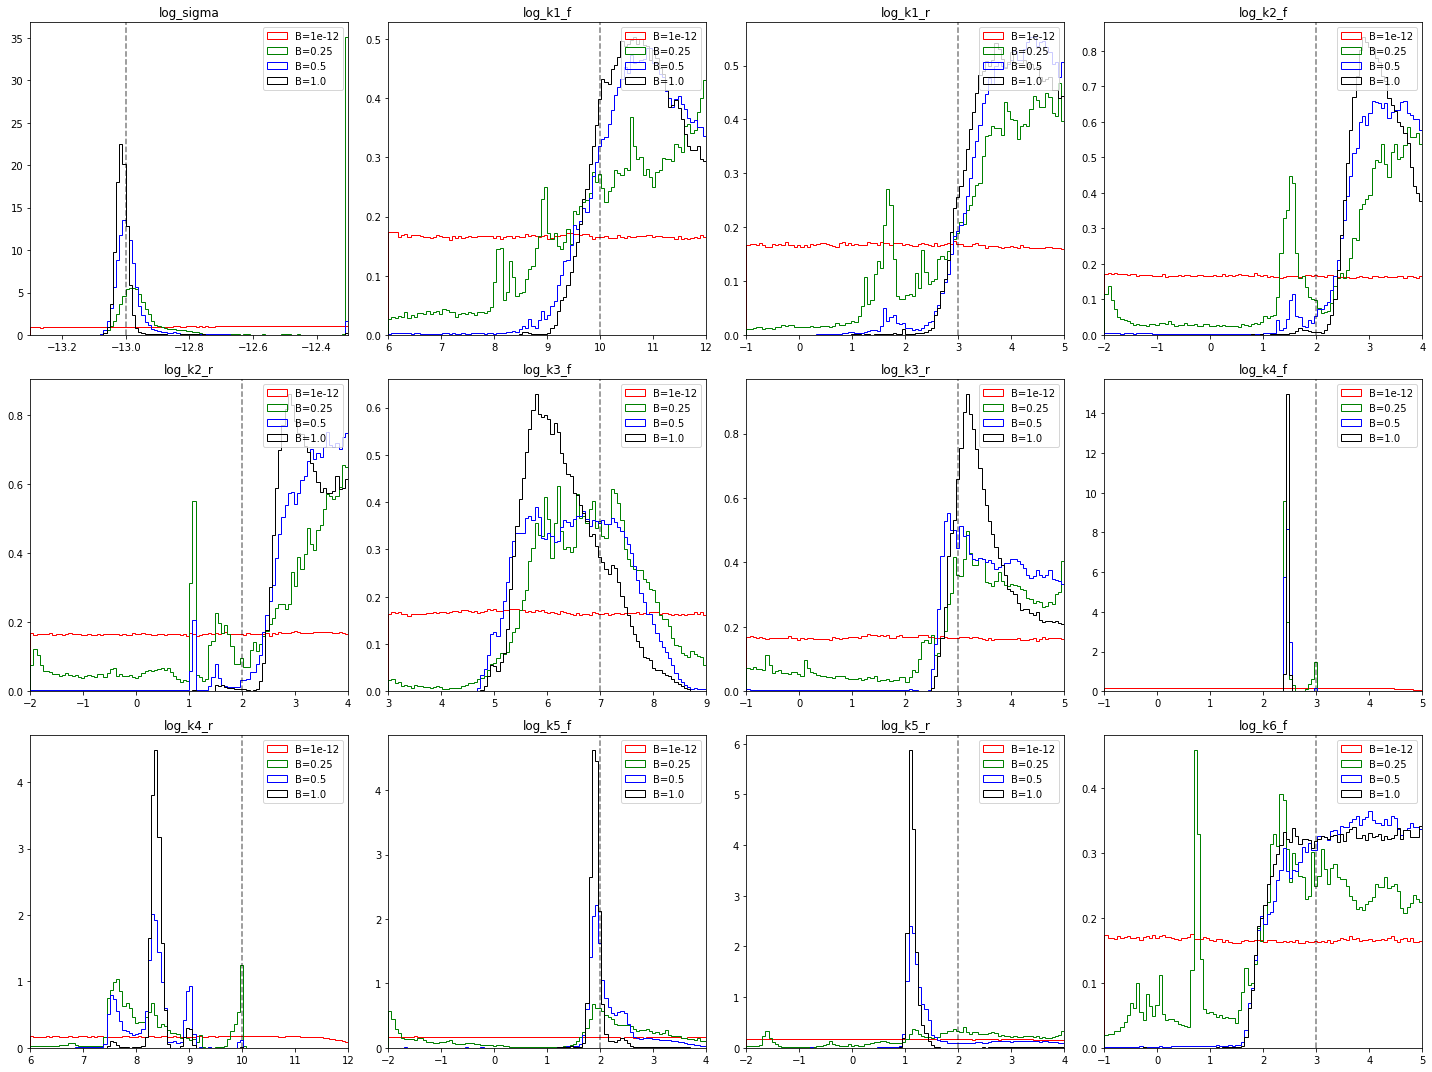

In [3]:
import corner

p_info = [
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
]

samples = [np.transpose(sampler.flatchain[i,:,:]) for i in range(n_temps)]
#colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple','black' ]
colors = ['red', 'green',  'blue', 'black' ]
assert(len(samples)==len(colors))

### 1D posterior plot
fig, ax = plt.subplots(3,4, figsize=(20,15))
axes = ax.flatten()

for i, ax_i in enumerate(axes):
    p_tmp = p_info[i]
    ax_i.set_title(f"{p_tmp[0]}")
    ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
    ax_i.set_xlim(p_tmp[1],p_tmp[2])
    
    
    for j, samples_t in enumerate(samples):
        ax_i.hist(samples_t[i], 100, histtype="step", color=colors[j], density=True, range=(p_tmp[1],p_tmp[2]), label=f'B={betas[j]}')
        ax_i.legend()
plt.tight_layout()
plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}_random.png')

In [4]:
import pandas as pd
df = pd.DataFrame(np.transpose(samples[-1])[::1000], columns=[p[0] for p in p_info])
print(df)
df.to_csv(f'12D_transporter_AIES_PT_B1_samples_s{seed}_random.csv', sep=',')



       log_sigma   log_k1_f  log_k1_r  log_k2_f  log_k2_r  log_k3_f  log_k3_r  \
0     -12.584917   9.726197  1.063410 -0.562179  0.224615  5.781824  1.997950   
1     -12.830888  10.177665  3.355714  2.964511  2.978179  5.353845  3.094416   
2     -12.993220  10.569389  4.014690  3.257391  3.556844  6.313534  3.331256   
3     -12.992761  10.824156  4.540477  3.345084  3.327526  5.870090  3.080438   
4     -13.010049  10.540472  3.944643  3.157401  3.301170  5.827456  3.069093   
...          ...        ...       ...       ...       ...       ...       ...   
14395 -13.011390   9.666802  3.439995  3.767981  3.238729  5.301066  3.001857   
14396 -13.040845  11.531523  3.679200  2.886805  3.486483  6.903609  3.757946   
14397 -13.027524  10.004155  4.035120  3.600829  3.166999  7.089133  4.439837   
14398 -13.018059  10.024889  3.086908  3.598625  3.302368  6.781528  4.376188   
14399 -13.028748  11.873135  3.724941  3.267663  2.982623  6.829447  4.110704   

       log_k4_f   log_k4_r 

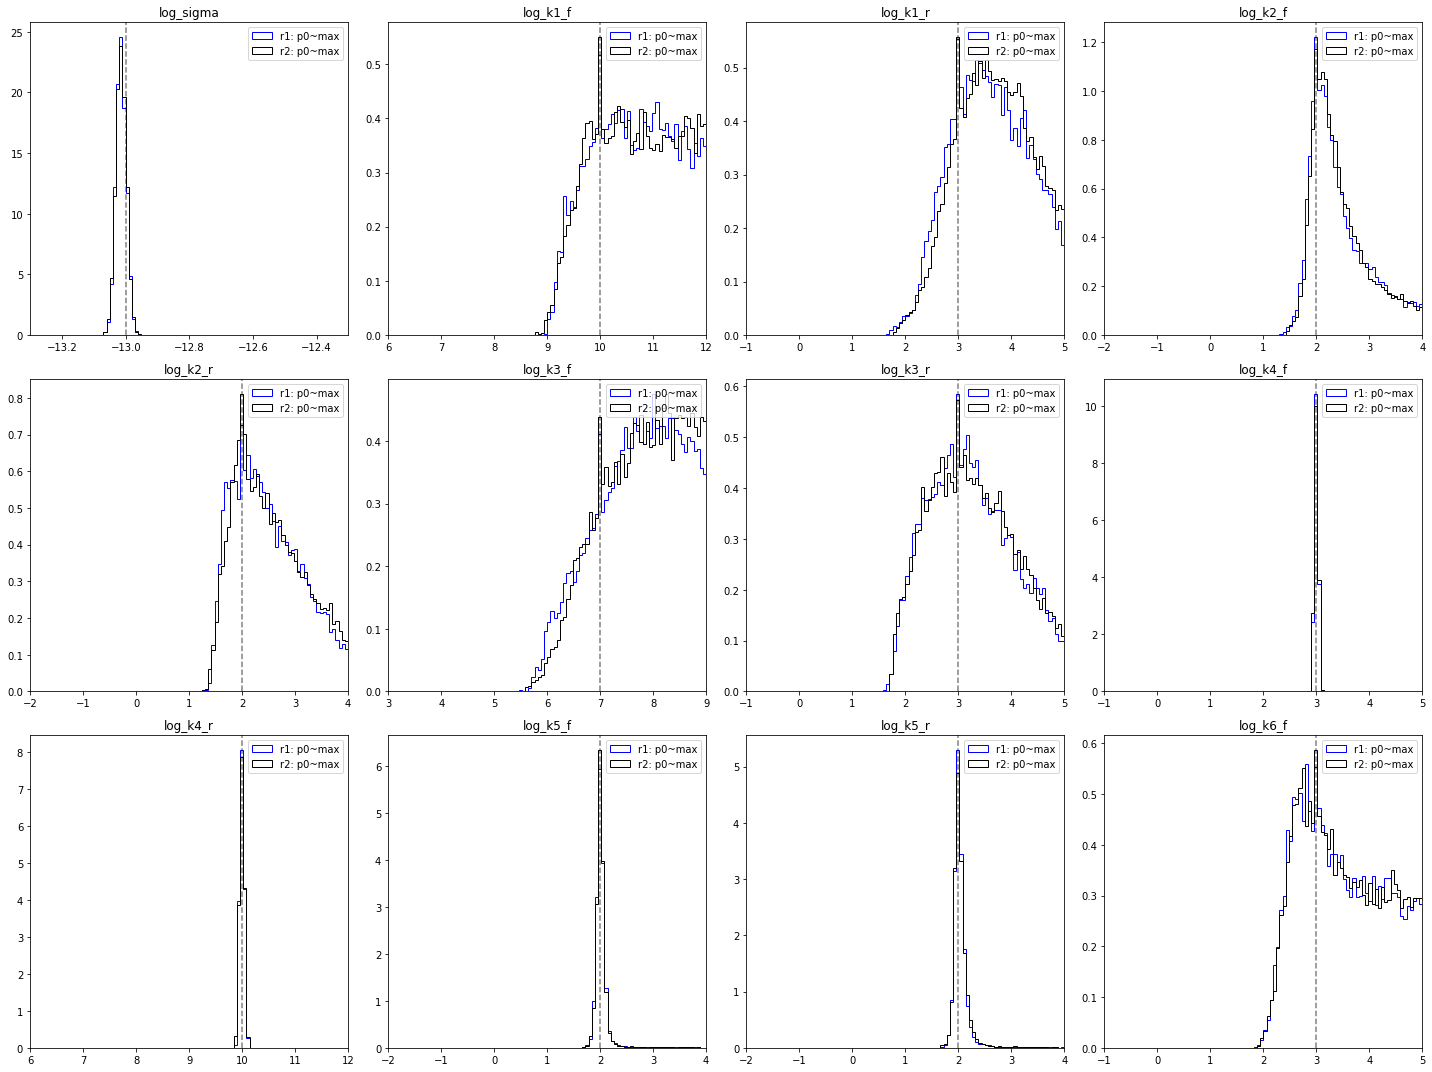

In [16]:

f1 = "12D_transporter_AIES_PT_B1_samples_s10.csv"
f2 = "12D_transporter_AIES_PT_B1_samples_s11.csv"
f3 = "12D_transporter_AIES_PT_B1_samples_s10_random.csv"


df1 = pd.read_csv(f1,usecols=[i+1 for i in range(n_dim)])
df2 = pd.read_csv(f2, usecols=[i+1 for i in range(n_dim)])
df3 = pd.read_csv(f3, usecols=[i+1 for i in range(n_dim)])

labels = ['r1: p0~max', 'r2: p0~max', 'r3: p0~rand']
colors = [ 'blue', 'black', 'red' ]
### 1D posterior plot
fig, ax = plt.subplots(3,4, figsize=(20,15))
axes = ax.flatten()

for i, ax_i in enumerate(axes):
    p_tmp = p_info[i]
    ax_i.set_title(f"{p_tmp[0]}")
    ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
    ax_i.set_xlim(p_tmp[1],p_tmp[2])
    

    ax_i.hist(df1.iloc[:, i], 100, histtype="step", color=colors[0], density=True, range=(p_tmp[1],p_tmp[2]), label=f'{labels[0]}')
    ax_i.hist(df2.iloc[:, i], 100, histtype="step", color=colors[1], density=True, range=(p_tmp[1],p_tmp[2]), label=f'{labels[1]}')
    #ax_i.hist(df3.iloc[:, i], 100, histtype="step", color=colors[2], density=True, range=(p_tmp[1],p_tmp[2]), label=f'{labels[2]}')
    ax_i.legend()
    
plt.tight_layout()
#plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}_random.png')

[-12.99879028 -13.00716363 -13.03706777 ... -13.03656851 -12.99986159
 -13.01451485]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[ 9.9997673   9.73875467 10.59051595 ... 11.64003259 10.89079967
 11.16361683]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.




0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[1.99783351 1.98377895 2.04046264 ... 2.82130816 1.97363443 2.05696379]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[2.0010346  1.94931694 2.1649391  ... 3.45544014 2.10286641 3.80705903]
14

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.




0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[7.00530236 7.86532115 6.5904496  ... 8.91114192 5.90183685 8.76783598]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[3.0002029  3.93195575 2.44715018 ... 3.39252547 1.87943837 2.93560314]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.




0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[2.99532474 3.00852948 3.00034724 ... 2.96041253 2.99063174 3.02912964]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[10.00544675 10.01135321 10.0004539  ...  9.94632847  9.98747324
 10.03838211]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.



0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[2.00540922 2.15358072 1.97161901 ... 1.90589564 2.00998165 1.89565428]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[1.99053874 2.15628129 2.01826467 ... 1.91754765 1.91922153 1.9828307 ]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.



0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[3.00357342 2.7984401  2.4738811  ... 4.15810911 3.3625215  3.16945354]
14400
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0


/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_1568/3557141727.py:29: UserWarning:

Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.



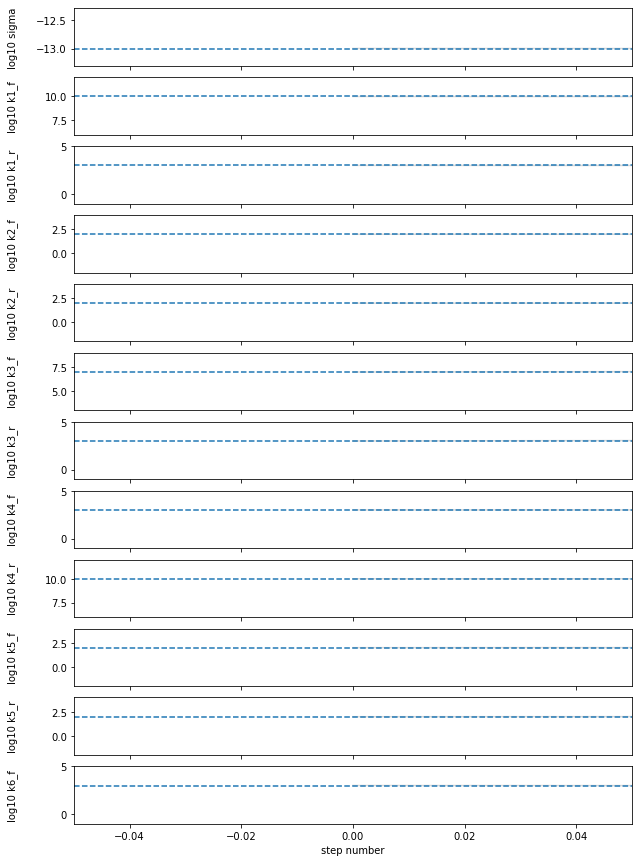

In [30]:
fig, axes = plt.subplots(n_dim, figsize=(10, 15), sharex=True)

n_steps = 120000
n_walkers = 120
n_dim = 12

labels = [
    'log10 sigma',
    'log10 k1_f',
    'log10 k1_r',
    'log10 k2_f',
    'log10 k2_r',
    'log10 k3_f',
    'log10 k3_r',
    'log10 k4_f',
    'log10 k4_r',
    'log10 k5_f',
    'log10 k5_r',
    'log10 k6_f',
]
for i in range(n_dim):
    ax = axes[i]
    for j in range(n_walkers):
        tmp = df1.iloc[n_steps*j:n_steps*(j+1),i].values
        print(tmp)
        print(len(tmp))
        ax.plot(tmp, "k", alpha=0.15)
    ax.axhline(p_info[i][3], ls='--')
    ax.set_xlim(0, len(tmp))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
    ax.set_ylim(p_info[i][1],p_info[i][2])

axes[-1].set_xlabel("step number");
#plt.savefig('p_mcmc_traj.png')